In [ ]:
# https://www.tensorflow.org/tutorials/images/segmentation?hl=ko

In [ ]:
!pip install tensorflow_datasets

  Using cached tensorflow_datasets-4.8.2-py3-none-any.whl (5.3 MB)
  Using cached etils-1.0.0-py3-none-any.whl (146 kB)
  Using cached promise-2.3.tar.gz (19 kB)
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
  Using cached tensorflow_metadata-1.12.0-py3-none-any.whl (52 kB)
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=5b4b44f22b063b5faaf39b0f41754107577aba8fe8bd6f13144119bfe115c2f3
  Stored in directory: c:\users\apollo\appdata\local\pip\cache\wheels\e1\e8\83\ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise


In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers

In [ ]:
# load dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
# split dataset
dataset_train = dataset['train']
dataset_test = dataset['test']

# normalize images
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask      


# resize imgees and masks to 224x224
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


# apply function to dataset
dataset_train = dataset_train.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_test = dataset_test.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [ ]:
#FCN VGG16
model_type = tf.keras.applications.vgg16
base_model = model_type.VGG16()
base_model.trainable = False # 학습이 되지 않도록 고정
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# add layers
map5 = base_model.layers[-5].output

# sixth convolution layer
# input_1 (InputLayer) [(None, 224, 224, 3)] 150,528 ?  4096 * 7 * 7 
conv6 = tf.keras.layers.Conv2D(filters = 4096,
                               kernel_size = (7,7),
                               padding = 'SAME',
                               activation = 'relu')(map5)

# 1x1 convolution layers
fcn4 = tf.keras.layers.Conv2D(filters = 4096,
                              kernel_size = (1,1),
                              padding = 'SAME',
                              activation = 'relu')(conv6)

fcn3 = tf.keras.layers.Conv2D(filters = 2,
                              kernel_size = (1,1),
                              padding = 'SAME',
                              activation = 'relu')(fcn4)

# Upsampling layers
fcn2 =  tf.keras.layers.Conv2DTranspose(filters = 512,
                                        kernel_size = (4,4),
                                        strides = (2,2),
                                        padding = 'SAME')(fcn3)

fcn1 =  tf.keras.layers.Conv2DTranspose(filters = 256,
                                        kernel_size = (4,4),
                                        strides = (2,2),
                                        padding = 'SAME')(fcn2 + base_model.layers[14].output)

output =  tf.keras.layers.Conv2DTranspose(filters = 3, #실제로는 filter = 2
                                          kernel_size = (16,16),
                                          strides = (8,8),
                                          padding = 'SAME',
                                          activation = 'softmax')(fcn1 + base_model.layers[10].output)

model = tf.keras.Model(inputs = base_model.inputs, outputs = output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:
# train model
EPOCHS = 10
BATCH_SIZE = 64
BUFFER_SIZE = 1000

dataset_train = dataset_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
dataset_test = dataset_test.batch(BATCH_SIZE)

In [ ]:
#compile model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model_history = model.fit(dataset_train, epochs=EPOCHS, steps_per_epoch=200, validation_data=dataset_test, validation_steps=50)

Epoch 1/10


C:\Users\apollo\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


200/200 [==============================] - 125s 565ms/step - loss: 0.4782 - accuracy: 0.8311 - val_loss: 0.3469 - val_accuracy: 0.8649
Epoch 2/10
200/200 [==============================] - 109s 547ms/step - loss: 0.2849 - accuracy: 0.8830 - val_loss: 0.3309 - val_accuracy: 0.8709
Epoch 3/10
200/200 [==============================] - 109s 546ms/step - loss: 0.2478 - accuracy: 0.8971 - val_loss: 0.3855 - val_accuracy: 0.8667
Epoch 4/10
200/200 [==============================] - 109s 547ms/step - loss: 0.2205 - accuracy: 0.9075 - val_loss: 0.3630 - val_accuracy: 0.8736
Epoch 5/10
200/200 [==============================] - 109s 546ms/step - loss: 0.2035 - accuracy: 0.9140 - val_loss: 0.3844 - val_accuracy: 0.8721
Epoch 6/10
200/200 [==============================] - 109s 547ms/step - loss: 0.1873 - accuracy: 0.9201 - val_loss: 0.4036 - val_accuracy: 0.8701
Epoch 7/10
200/200 [==============================] - 109s 546ms/step - loss: 0.1834 - accuracy: 0.9216 - val_loss: 0.4333 - val_accura

In [ ]:
# plot loss and accuracy
def plot_metrics(history):
    metrics =  ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(1,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='green', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'accuracy':
            plt.ylim([0,1])
        else:
            plt.ylim([0,1])
        plt.legend()
    plt.show()

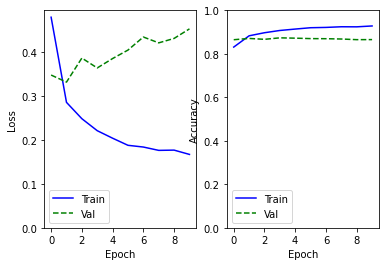

In [ ]:
plot_metrics(model_history)

In [ ]:
import matplotlib.pyplot as plt

2/2 [==============================] - 0s 159ms/step


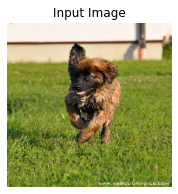

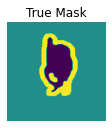

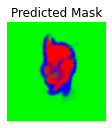

2/2 [==============================] - 0s 172ms/step


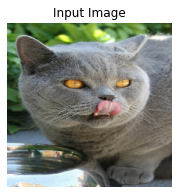

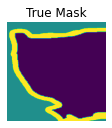

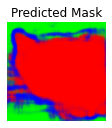

2/2 [==============================] - 0s 173ms/step


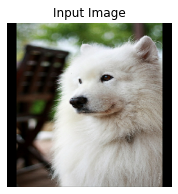

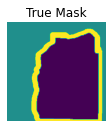

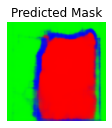

2/2 [==============================] - 0s 174ms/step


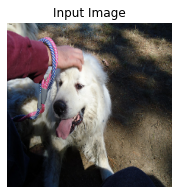

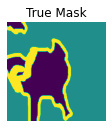

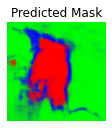

2/2 [==============================] - 0s 174ms/step


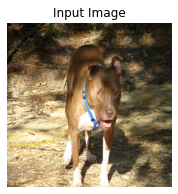

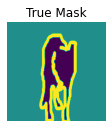

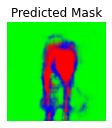

2/2 [==============================] - 0s 163ms/step


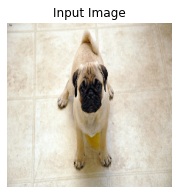

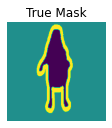

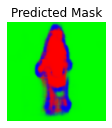

2/2 [==============================] - 0s 171ms/step


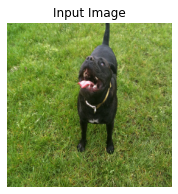

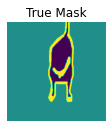

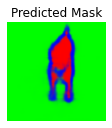

2/2 [==============================] - 0s 171ms/step


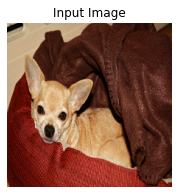

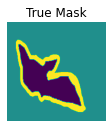

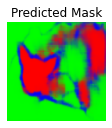

2/2 [==============================] - 0s 171ms/step


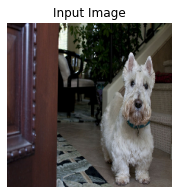

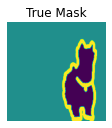

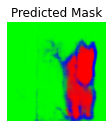

2/2 [==============================] - 0s 171ms/step


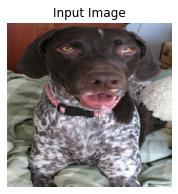

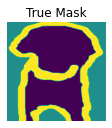

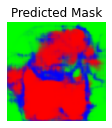

In [ ]:
for image, mask in dataset_test.take(10):
    pred_mask = model.predict(image)
    plt.figure(figsize=(10, 10))

    display_list = [image[0], mask[0], pred_mask[0]]
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

        plt.show()